In [1]:
import os
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

from src.utils.data_utils import get_related_videos_with_keywords, keyword_searcher
from src.utils.general_utils import plot_wordcloud
from src.utils.evaluation_utils import diff_in_diff

# supress all warnings
import warnings
warnings.filterwarnings("ignore")
DATA_PATH = "/Users/zahrataghizadeh/Desktop/ADA/YouNiverse"

In [2]:
# Load channel dataset
df_ch_f = pd.read_csv(
    os.path.join(DATA_PATH, "df_channels_en.tsv"), 
    compression="infer", 
    sep="\t"
)
df_ch_f["join_date"] = pd.to_datetime(df_ch_f["join_date"])

In [ ]:
# Load timeseries dataset
df_ts_f = pd.read_csv(
    os.path.join(DATA_PATH, "df_timeseries_en.tsv.gz"), 
    compression="infer", 
    sep="\t"
)
df_ts_f["datetime"] = pd.to_datetime(df_ts_f["datetime"])

In [ ]:
# Load video dataset without descriptions and tags
df_vd_f = pd.read_feather(
    os.path.join(DATA_PATH, "yt_metadata_helper.feather")
)

In [ ]:
# overview
df_vd_f.head()
# Examine NaN values
print("Number of NaN values in each column:")
print(df_vd_f.isnull().sum())



In [ ]:
# overview
df_ch_f.head(10)
# Examine NaN values
print("Number of NaN values in each column:")
print(df_ch_f.isnull().sum())

# Check channel with join_date NaN
df_ch_f[df_ch_f["join_date"].isnull()]
# Remove channel with join_date NaN
df_ch_f = df_ch_f.dropna(subset=["join_date"])
print("Number of channels collected: ", df_ch_f.shape[0])


In [ ]:
# Plot the number of channels per category
plt.figure(figsize=(15, 6))
sns.countplot(x="category_cc", data=df_ch_f, order=df_ch_f.category_cc.value_counts().index)
plt.xticks(rotation=45)
plt.title("Number of channels per category")
plt.show()
df_ch_f.category_cc.value_counts()

In [ ]:
# Plot pie chart percentage of channels per category
plt.figure(figsize=(10, 10))
df_ch_f.category_cc.value_counts().plot.pie(autopct='%1.1f%%')
plt.title("Percentage of channels per category")
plt.ylabel("")
plt.legend()
plt.show()


In [ ]:
# Number of channels joined over time line plot
plt.figure(figsize=(15, 6))
df_ch_f["join_date"].value_counts().sort_index().plot()
plt.title("Number of channels joined over time")
plt.show()


In [ ]:
# Culmulative number of channels joined over time
cumulative_counts = df_ch_f["join_date"].value_counts().sort_index().cumsum()

plt.figure(figsize=(15, 6))
cumulative_counts.plot()
plt.title("Cumulative number of channels joined over time")
plt.show()

In [ ]:
# Culumative number of channels joined over time per category
plt.figure(figsize=(15, 6))
df_ch_f.groupby(["join_date", "category_cc"]).size().unstack().cumsum().plot()
plt.title("Cumulative number of channels joined over time per category")
plt.legend(title="Category", bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
# Number of channels joined per month for each year
df_ch_f["year"] = df_ch_f["join_date"].dt.year.astype(int)
df_ch_f["month"] = df_ch_f["join_date"].dt.month

monthly_counts = df_ch_f.groupby(["year", "month"]).size().reset_index(name="channel_count")

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x="month", y="channel_count", hue="year", palette="tab10", marker="o")

plt.xlabel("Month")
plt.ylabel("Number of channels joined")
plt.title("Number of channels joined per month for each year")
plt.legend(title="Year", loc="upper right")
plt.xticks(range(1, 13), 
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

In [ ]:
# Number of channels of different categories joined per year
plt.figure(figsize=(15, 6))
df_ch_f.groupby([df_ch_f["join_date"].dt.year, "category_cc"]).size().unstack().plot(colormap="tab20")
plt.title("Number of channels of joined per year")
plt.legend(title="Category", bbox_to_anchor=(1, 1))
plt.show()

## The Start of P3

In [5]:
df_ch_sports = df_ch_f[df_ch_f["category_cc"] == "Sports"]

In [ ]:
# Number of channels joined per month for each year
df_ch_sports_copy = df_ch_sports.copy()
df_ch_sports_copy["join_year"] = df_ch_sports_copy["join_date"].dt.year.astype(int)
df_ch_sports_copy["join_month"] = df_ch_sports_copy["join_date"].dt.month
monthly_counts = df_ch_sports_copy.groupby(["join_year", "join_month"]).size().reset_index(name="channel_count")

plt.figure(figsize=(12, 6))
sns.lineplot(data=monthly_counts, x="join_month", y="channel_count", hue="join_year", palette="tab10", marker="o")

plt.xlabel("Month")
plt.ylabel("Number of sport channels joined")
plt.title("Number of sport channels joined per month for each year")
plt.legend(title="Year", loc="upper right")
plt.xticks(range(1, 13), 
           ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
plt.show()

In [ ]:
# Merge sports channels with timeseries dataset
df_ch_ts_sports = pd.merge(df_ts_f, df_ch_sports, on="channel", how="inner")

In [ ]:
def plot_sum_delta_amount_overtime(df, delta_cols: list[str]):
    # Create a new column that combines year and month
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    df['year_month'] = df['year'].astype(
        str) + '-' + df['month'].astype(str).str.zfill(2)

    # Group by the new 'year_month' column and sum the "delta" counts
    year_month_view_count = df.groupby('year_month')[delta_cols].sum().reset_index()
    
    # print(year_month_view_count.head())

    # Plot the data
    plt.figure(figsize=(40, 12))
    for delta_col in delta_cols:
        plt.plot(year_month_view_count['year_month'],
                 year_month_view_count[delta_col], marker='o', label=delta_col)
    plt.title(f'Sum {delta_cols} over time')
    plt.xlabel('Time')
    plt.ylabel('')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.legend()
    plt.show()

In [ ]:
plot_sum_delta_amount_overtime(df_ch_ts_sports, ["delta_views"])
plot_sum_delta_amount_overtime(df_ch_ts_sports, ["delta_subs"])
plot_sum_delta_amount_overtime(df_ch_ts_sports, ["delta_videos"])


In [ ]:
# Plot X by month for each year
def plot_x_by_month_for_each_year(df, x_col: str, years=None):
    df['year'] = df['datetime'].dt.year
    df['month'] = df['datetime'].dt.month
    if years is not None:
        df = df[df['year'].isin(years)]
        
    data = df.groupby(['year', 'month'])[x_col].sum().reset_index()
    
    pivot_data = data.pivot(index='month', columns='year', values=x_col)
    
    pivot_data.plot(kind='line', figsize=(15, 8))
    plt.title(f'{x_col} by month for each year')
    plt.xlabel('Month')
    plt.ylabel(x_col)
    plt.xticks(range(1, 13), 
               ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"])
    plt.legend(title='Year')
    plt.show()
        

In [ ]:
plot_x_by_month_for_each_year(df_ch_ts_sports, 'delta_views')
plot_x_by_month_for_each_year(df_ch_ts_sports, 'delta_subs')
plot_x_by_month_for_each_year(df_ch_ts_sports, 'delta_videos')

In [2]:
# Load the full video dataset
pq_sports = pq.ParquetFile(os.path.join(DATA_PATH, "filtered_sport_category_metadata.parquet"))
df_vd_sports = pq_sports.read().to_pandas()

# Change upload_date to datetime
df_vd_sports["upload_date"] = pd.to_datetime(df_vd_sports["upload_date"], format="%Y-%m-%d %H:%M:%S")

In [3]:
df_vd_sports_copy = df_vd_sports.copy()
df_vd_sports.head(5)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:57.427254,Can I catch 100 lbs of catfish LIVE. Me and Ja...,35.0,JOeSxtcNdHQ,8620,1673.0,"catfishing,fishing,fishing challenge,catfish,c...",Catching 100 lbs of Catfish 🔴Live,2019-10-01,48737.0
1,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.108323,,15.0,EPMLTw2zINw,355,1297.0,,big cat,2019-10-01,19999.0
2,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:58.773085,Are you ready to enter the high fashion world ...,78.0,Y1_pK68iSYQ,603,3305.0,"Catfishing,how to catch catfish,fishing,classy...",Classy Catfishing - How to Catch Catfish the P...,2019-09-28,58518.0
3,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:39:59.465346,Saltwater fishing out of Newquay Cornwall UK. ...,70.0,jF8TSo3ZfTc,1426,1889.0,"Fishing,Fishing uk,Angling,Sea angling,sea ang...",2 Day Saltwater Fishing Catch & Cook - UK Sea ...,2019-09-21,71998.0
4,Sports,UCzWn_gTaXyH5Idyo8Raf7_A,2019-11-03 16:40:00.188768,My family spent 3 weeks touring England and fi...,73.0,Gp00dNaVouo,990,2699.0,"Fishing,catfish,wels catfish,how to catch catf...",How to Catch Wels Catfish - Fishing for Catfis...,2019-09-14,101924.0


In [ ]:
def get_all_tags(df: pd.DataFrame) -> list[str]:
    df['tags'] = df['tags'].str.lower()
    df['tags'] = df['tags'].str.replace("world cup", "world_cup")
    df['tags'] = df['tags'].str.replace("table tennis", "table_tennis")
    df['tags'] = df['tags'].str.replace("ping pong", "table_tennis")
    
    all_tags = []
    for tags in df['tags']:
        tag_list = tags.split(",") # "a, b c, d" -> ["a", "b c", "d"]
        for sentence in tag_list:
            all_tags.extend(sentence.split()) # "b c" -> ["b", "c"]
    
    return all_tags

In [8]:
import re
def replace_phrases_in_tokens(tokens, replacements):
    # replacements could be a dict, e.g. {"world cup": "world_cup", "table tennis": "table_tennis"}
    new_tokens = []
    # Join tokens into a string to detect multi-word phrases
    joined_text = " ".join(tokens)

    for phrase, replacement in replacements.items():
        # Use a regex with word boundaries again
        joined_text = re.sub(rf"\b{phrase}\b", replacement, joined_text)

    # Re-tokenize after replacements
    new_tokens = joined_text.split()
    return new_tokens

import re


['this', 'is', 'the', 'world_cup', 'final', 'world_cupoo', 'isworld', 'cup']


In [8]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zahrataghizadeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zahrataghizadeh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [17]:

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_tags_column(df):
    # Lowercase
    df['tags'] = df['tags'].str.lower()
    # Replace multi-word terms
    df['tags'] = df['tags'].str.replace("world cup", "world_cup")
    df['tags'] = df['tags'].str.replace("table tennis", "table_tennis")
    # Remove punctuation
    df['tags'] = df['tags'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return df

def full_tokenization_pipeline(df):
    all_tokens = []
    for tag_str in df['tags']:
        # Tokenize
        tokens = []
        for chunk in tag_str.split(','):
            tokens.extend(chunk.strip().split())
        # Remove stopwords
        tokens = [t for t in tokens if t not in stop_words]
        # Filter tokens
        tokens = [t for t in tokens if len(t) > 1]
        
        # Lemmatize
        tokens = [lemmatizer.lemmatize(t) for t in tokens]

        all_tokens.extend(tokens)
        
    return all_tokens

# Example usage:
df_vd_sports_copy = preprocess_tags_column(df_vd_sports_copy)
all_cleaned_tags = full_tokenization_pipeline(df_vd_sports_copy)


In [18]:
from collections import Counter

tag_counts = Counter(all_cleaned_tags)
# Get the top 20 most common tags
top_20 = tag_counts.most_common(20)
print("Top 20 tags:", top_20)


Top 20 tags: [('v', 749718), ('football', 442914), ('sport', 343112), ('league', 189531), ('world', 131488), ('wrestling', 129638), ('basketball', 126710), ('tv', 110465), ('game', 103019), ('martial', 95664), ('de', 92804), ('hockey', 88361), ('nba', 82787), ('team', 82473), ('city', 80701), ('state', 80022), ('fc', 79065), ('fishing', 75387), ('cricket', 74925), ('news', 73849)]


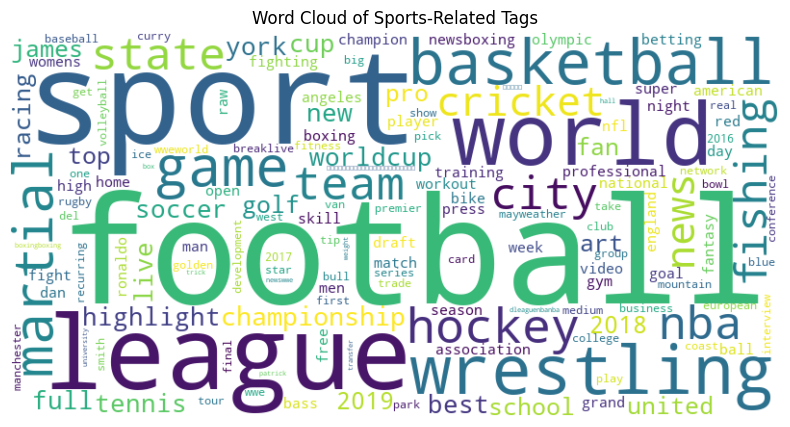

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# remove the tags witch the length is less than 2
tag_counts = {k: v for k, v in tag_counts.items() if len(k) > 2}
# Convert Counter to dict for WordCloud
tag_dict = dict(tag_counts)

wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    max_words=200
).generate_from_frequencies(tag_dict)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Sports-Related Tags")
plt.show()


In [20]:
# print the top 20 tags after removing the tags with length less than 2
top_20 = Counter(tag_counts).most_common(20)
print("Top 20 tags after removing tags with length less than 2:", top_20)

Top 20 tags after removing tags with length less than 2: [('football', 442914), ('sport', 343112), ('league', 189531), ('world', 131488), ('wrestling', 129638), ('basketball', 126710), ('game', 103019), ('martial', 95664), ('hockey', 88361), ('nba', 82787), ('team', 82473), ('city', 80701), ('state', 80022), ('fishing', 75387), ('cricket', 74925), ('news', 73849), ('championship', 71663), ('soccer', 65797), ('tennis', 65286), ('highlight', 64235)]


In [21]:
# get the oldest and newest video
oldest_video = df_vd_sports_copy.loc[df_vd_sports_copy["upload_date"].idxmin()]
print("Oldest video:")
print(oldest_video)

newest_video = df_vd_sports_copy.loc[df_vd_sports_copy["upload_date"].idxmax()]
print("Newest video:")
print(newest_video)

Oldest video:
categories                                                  Sports
channel_id                                UCs0ACZIa1m4ecu2zijr-8Sg
crawl_date                              2019-11-02 05:58:49.815667
description      First backflip on Youtube....Yeah!!!  This is ...
dislike_count                                                123.0
display_id                                             VaLXzI92t9M
duration                                                        60
like_count                                                  4848.0
tags             youtubecrazystuntbackflipcobaltgruvjumpingskil...
title                                  First Back Flip on Youtube!
upload_date                                    2005-05-24 00:00:00
view_count                                                291474.0
Name: 4354111, dtype: object
Newest video:
categories                                                  Sports
channel_id                                UCSAys3yHQjH5n8y082xgHNg
crawl

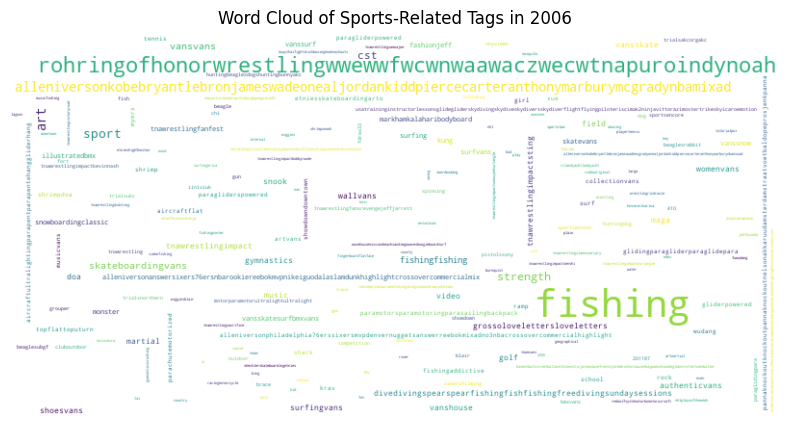

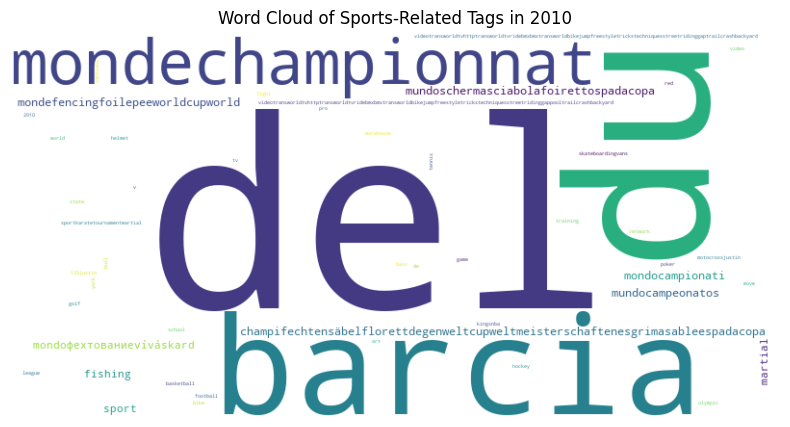

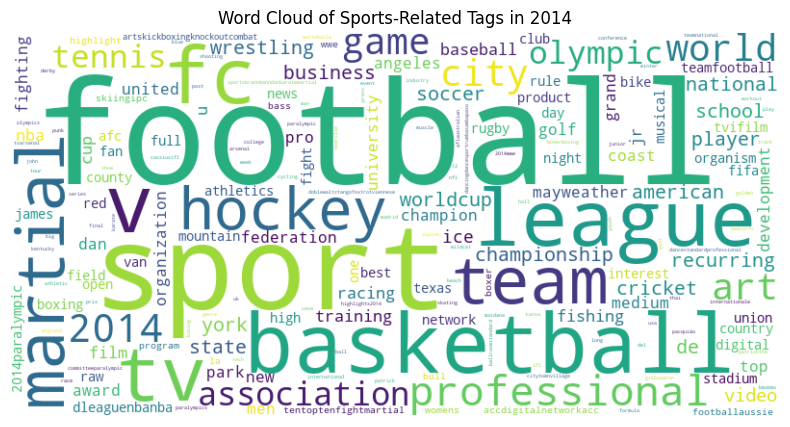

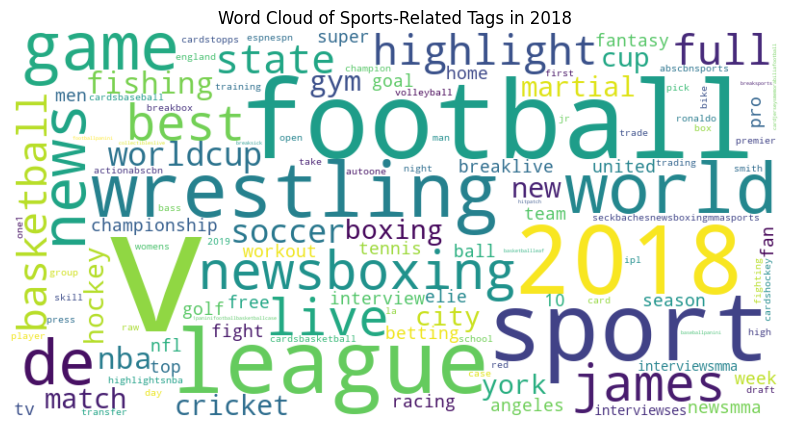

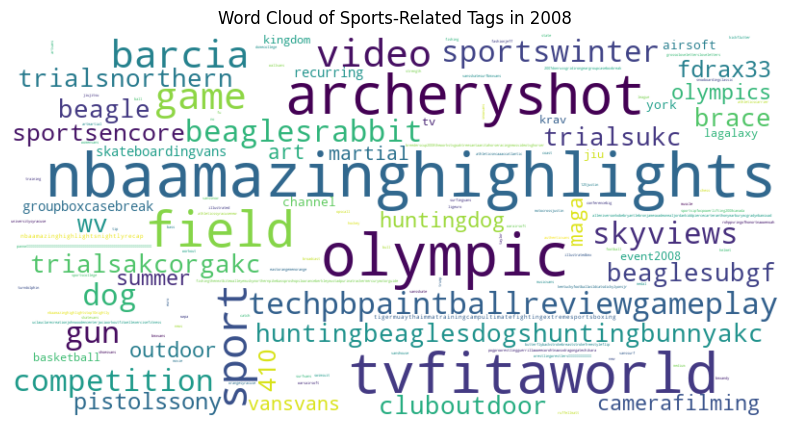

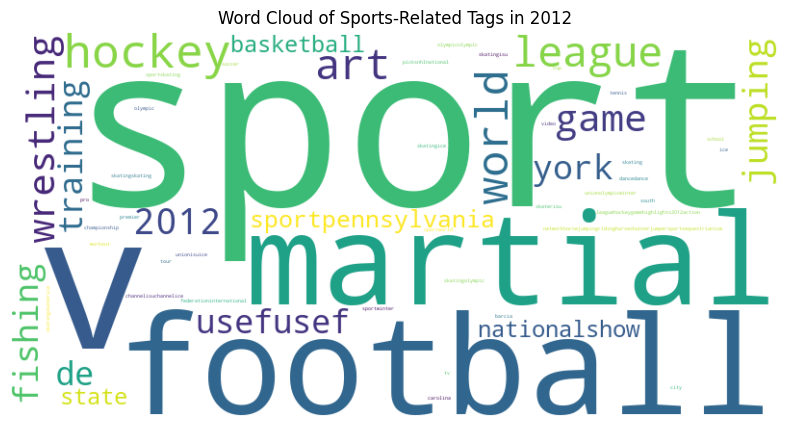

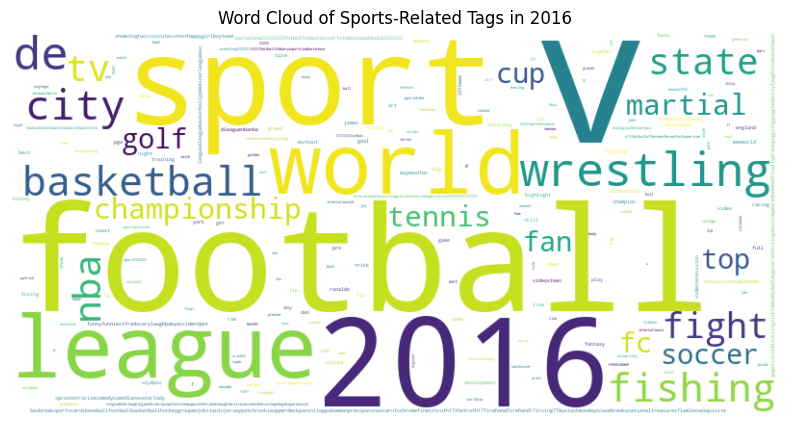

In [24]:
def year_wordcloud(df_vd_sports, year):
    df_vd_sports_2018 = df_vd_sports[df_vd_sports['upload_date'].dt.year == year]
    all_cleaned_tags_2018 = full_tokenization_pipeline(df_vd_sports_2018)
    tag_counts_2018 = Counter(all_cleaned_tags_2018)
    # Generate a word cloud specifically for 2018
    tag_dict_2018 = dict(tag_counts_2018)
    wordcloud_2018 = WordCloud(
        width=800,
        height=400,
        background_color='white',
        max_words=200
    ).generate_from_frequencies(tag_dict_2018)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud_2018, interpolation='bilinear')
    plt.axis('off')
    plt.title("Word Cloud of Sports-Related Tags in " + str(year))
    plt.show()

# FIFA World Cup 
year_wordcloud(df_vd_sports_copy, 2006) # Also Winter Olympics (Turin)
year_wordcloud(df_vd_sports_copy, 2010) # Also Winter Olympics (Vancouver)
year_wordcloud(df_vd_sports_copy, 2014) # Also Winter Olympics (Sochi)
year_wordcloud(df_vd_sports_copy, 2018) #  Also Winter Olympics (Pyeongchang)

# Olympics
year_wordcloud(df_vd_sports_copy, 2008)  # Also Euro 2008
year_wordcloud(df_vd_sports_copy, 2012)  # Also Euro 2012
year_wordcloud(df_vd_sports_copy, 2016)  # Also Euro 2016








In [43]:
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt

# Ensure your DataFrame has a datetime column (upload_date) for time-based analysis
# If not done already:
df_vd_sports["upload_date"] = pd.to_datetime(df_vd_sports["upload_date"], errors="coerce")

# Let's say we focus on a few tags of interest
tags_of_interest = ["world_cup", "olympics", "soccer", "cricket", "tennis", "basketball", "baseball", "football", "golf", "rugby", "table_tennis", "nba", 'gymnastics', 'volleyball',
                    'swimming', 'badminton', 'wrestling', 'skiing']

# We'll iterate through the DataFrame and count how often these tags appear each year
df_vd_sports["year"] = df_vd_sports["upload_date"].dt.year

# Initialize a dictionary to hold counts per year for each tag
tag_year_counts = {tag: Counter() for tag in tags_of_interest}

for _, row in df_vd_sports.iterrows():
    # Tokenize tags for this video
    tokens = []
    for chunk in row["tags"].split(','):
        tokens.extend(chunk.strip().split())
    
    # Check which of the tags_of_interest are present
    year = row["year"]
    for tag in tags_of_interest:
        if tag in tokens:
            tag_year_counts[tag][year] += 1

# Convert these counters into a DataFrame for easier plotting
df_tag_year = pd.DataFrame.from_dict({tag: dict(counts) for tag, counts in tag_year_counts.items()}, orient='index').fillna(0)
df_tag_year = df_tag_year.transpose()  # Years become index, tags become columns

df_tag_year.head()


,olympics,soccer,cricket,tennis,basketball,baseball,football,golf,rugby,nba,gymnastics,volleyball,swimming,badminton,wrestling,skiing
2012,913.0,1153.0,331.0,929.0,1199.0,305.0,3957.0,569.0,436.0,604.0,126.0,162.0,387.0,144.0,1776.0,81.0
2014,1068.0,6017.0,2027.0,2798.0,12032.0,2354.0,39306.0,1994.0,1788.0,3819.0,665.0,489.0,447.0,406.0,5318.0,437.0
2017,179.0,5149.0,4480.0,3870.0,11865.0,1259.0,23808.0,3965.0,1408.0,10138.0,1451.0,2035.0,308.0,133.0,17310.0,162.0
2019,319.0,5174.0,11472.0,3230.0,11285.0,1550.0,26694.0,4663.0,2127.0,12341.0,1805.0,3397.0,572.0,734.0,22882.0,144.0
2016,632.0,4527.0,1275.0,2515.0,7128.0,945.0,17415.0,3851.0,1053.0,7733.0,1453.0,1610.0,386.0,140.0,11045.0,45.0


In [44]:
df_tag_year_copy = df_tag_year.copy()

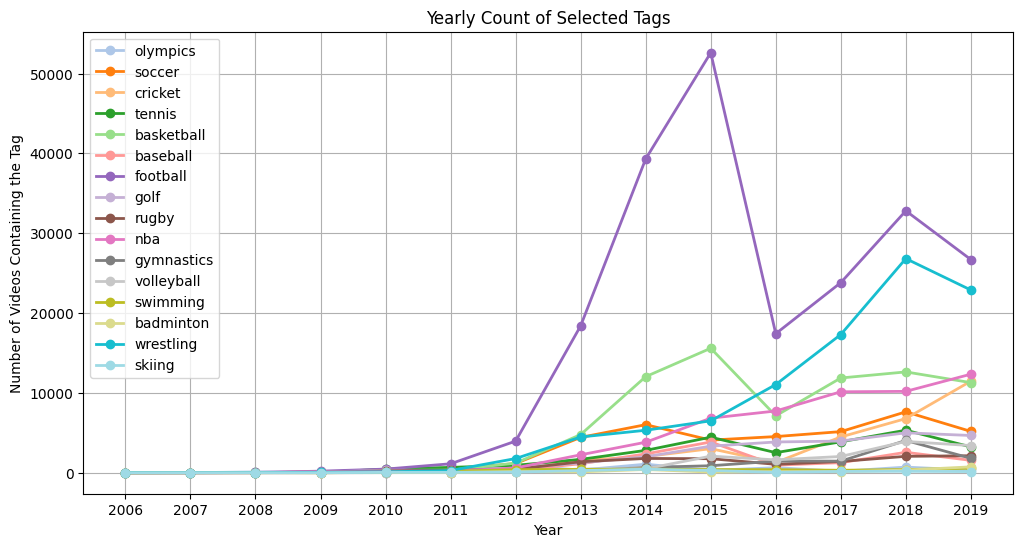

In [47]:
import matplotlib.cm as cm
n_tags = len(tags_of_interest)

# Use tab20, which has 20 distinct colors
# If n_tags > 20, you'll start repeating colors. Consider another approach if needed.
cmap = cm.get_cmap('tab20', n_tags)

plt.figure(figsize=(12, 6))
for i, tag in enumerate(tags_of_interest):
    if tag in df_tag_year_copy.columns:
        color = cmap(i)
        plt.plot(df_tag_year_copy.index, df_tag_year_copy[tag], marker='o', label=tag, color=color, linewidth=2)

plt.title("Yearly Count of Selected Tags")
plt.xlabel("Year")
plt.ylabel("Number of Videos Containing the Tag")
plt.xticks(sorted(df_tag_year_copy.index.dropna()))
plt.legend()
plt.grid(True)
plt.show()

## Description

In [6]:
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download resources for NLTK if not already done
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_description(text):
    if pd.isnull(text):
        return []
    # Lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenize on whitespace
    tokens = text.split()
    # Remove stopwords and numeric-only tokens, and lemmatize
    tokens = [lemmatizer.lemmatize(t) for t in tokens if t not in stop_words and not t.isnumeric() and len(t) > 1]
    return tokens

# Apply preprocessing to each video's description
df_vd_sports_copy = df_vd_sports.copy()

df_vd_sports_copy["tokens"] = df_vd_sports_copy["description"].apply(preprocess_description)


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/zahrataghizadeh/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/zahrataghizadeh/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
from collections import Counter

all_tokens = []
for token_list in df_vd_sports_copy["tokens"]:
    all_tokens.extend(token_list)

freq_dist = Counter(all_tokens)
top_20 = freq_dist.most_common(20)
print("Top 20 most common words in descriptions:", top_20)


Top 20 most common words in descriptions: [('subscribe', 1689157), ('video', 1656276), ('follow', 1642660), ('u', 1508425), ('twitter', 1484937), ('facebook', 1361424), ('instagram', 1148701), ('sport', 1062925), ('channel', 1017689), ('youtube', 964564), ('like', 951172), ('world', 840377), ('get', 791140), ('nba', 783307), ('team', 762940), ('v', 719959), ('game', 714606), ('news', 680930), ('new', 649269), ('watch', 646237)]


In [10]:
tags_of_interest = ["world_cup", "olympics", "soccer", "cricket", "tennis", "basketball", "baseball", "football", "golf", "rugby", "table_tennis", "nba", 'gymnastics', 'volleyball',
                    'swimming', 'badminton', 'wrestling', 'skiing']

keywords_of_interest = ["final", "highlight", "training", "injury", "soccer", "cricket", "basketball"] + tags_of_interest

df_vd_sports_copy["upload_date"] = pd.to_datetime(df_vd_sports_copy["upload_date"], errors="coerce")
df_vd_sports_copy["year"] = df_vd_sports_copy["upload_date"].dt.year


# Initialize a dictionary to hold counts per year for each keyword
keyword_year_counts = {kw: Counter() for kw in keywords_of_interest}

for _, row in df_vd_sports_copy.iterrows():
    year = row["year"]
    tokens = row["tokens"]
    # If the tokens contain our keyword, increment the count for that year
    for kw in keywords_of_interest:
        if kw in tokens:
            keyword_year_counts[kw][year] += 1

# Convert these counters into a DataFrame for plotting
df_keyword_year = pd.DataFrame.from_dict({kw: dict(counts) for kw, counts in keyword_year_counts.items()}, orient='index').fillna(0)
df_keyword_year = df_keyword_year.transpose()  # years become the index, keywords become columns
df_keyword_year = df_keyword_year.sort_index() # Ensure years are in ascending order



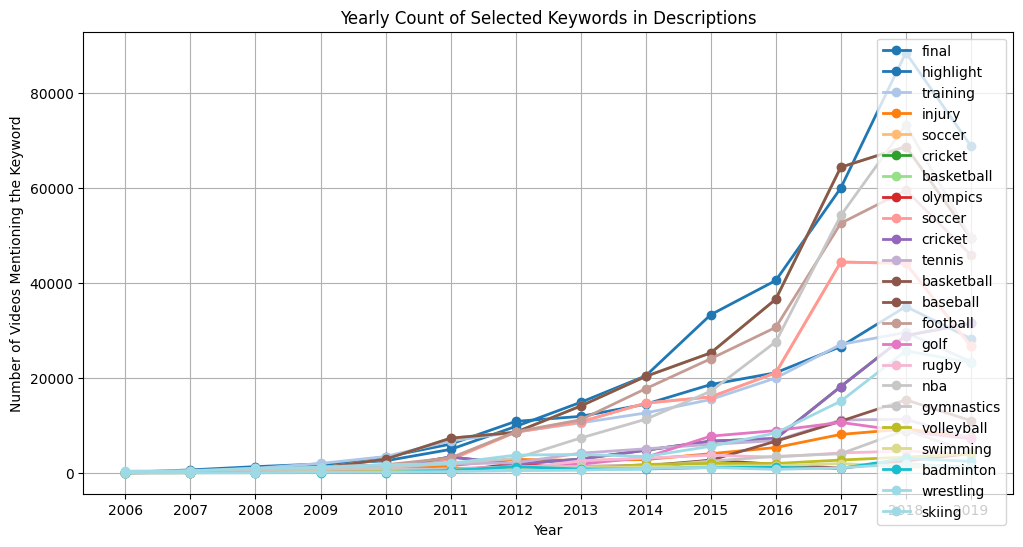

In [11]:
import matplotlib.cm as cm

n_keywords = len(keywords_of_interest)
cmap = cm.get_cmap('tab20', n_keywords)  # tab20 is good for up to 20 distinct colors

plt.figure(figsize=(12, 6))
for i, kw in enumerate(keywords_of_interest):
    if kw in df_keyword_year.columns:
        color = cmap(i)
        plt.plot(df_keyword_year.index, df_keyword_year[kw], marker='o', label=kw, color=color, linewidth=2)

plt.title("Yearly Count of Selected Keywords in Descriptions")
plt.xlabel("Year")
plt.ylabel("Number of Videos Mentioning the Keyword")
plt.xticks(sorted(df_keyword_year.index.dropna().astype(int)))  # Ensure integer years on x-axis
plt.legend()
plt.grid(True)
plt.show()
